In [36]:
import numpy as np
import matplotlib.pyplot as plt

Source:

https://hovey.github.io/docs/Hovey_2022_Bezier_B-Spline_SAND2022-7702_C.pdf

(read later) https://github.com/alexshtf/alexshtf.github.io/blob/master/assets/bernstein_basis.ipynb


* Cubic polynomial -  order = degree  = 3
$$f^p(x) = \sum_{i=0}^{p} a_i x^i$$

Bezier curve is parametrized via parameter $t$ and with control point(-s)
$$\vec{P}_i = \{x_i, y_i,\dots\}$$
Bezier curve of degree $p$ will have $p+1$ control points
* line - degree $1$ has $2$ control points

## Bezier line

is a linear interpolation between two control points
$$\vec{C}(t;\vec{P}_0,\vec{P}_1) =  (1-t)\vec{P}_0 + t \vec{P}_1$$

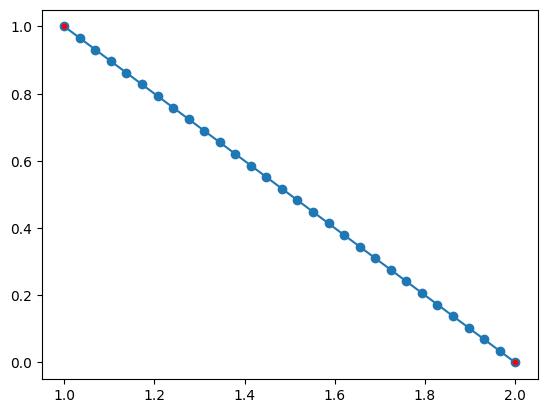

In [37]:
P0, P1 = P = np.array([[1,1],[2,0]])    # P0,P1 of shape (2,)

bezier_line = lambda t, P0, P1: (1-t)*P0 + t* P1
b1 = lambda t: bezier_line(t.reshape((-1,1)), P0, P1) # reshape times to (N, 1) to broadcast with (2,) -> (N,2)
times = np.linspace(0,1,30)
p1 = b1(times).T
plt.plot(*p1, '-o')
#plt.xlim(0.75,2.5)
#plt.ylim(-0.5,1.5)
plt.scatter(*P.T, c='r', s = 10, zorder = 10)


## Bezier Quadratic

is a linear interpolation of linear interpolations (xD)

given
$$\vec{Q}_0(t;\vec{P}_0,\vec{P}_1) =  (1-t)\vec{P}_0 + t \vec{P}_1$$
$$\vec{Q}_1(t;\vec{P}_1,\vec{P}_2) =  (1-t)\vec{P}_1 + t \vec{P}_2$$

we linearly interpolate
$$\vec{Q}(t;\vec{Q}_0(t),\vec{Q}_1(t)) =  (1-t)\vec{Q}_0(t) + t \vec{Q}_1(t)$$


We can show how each point on Bezier quadratic is linear interpolation between two points formed by linear interpolation between anchors

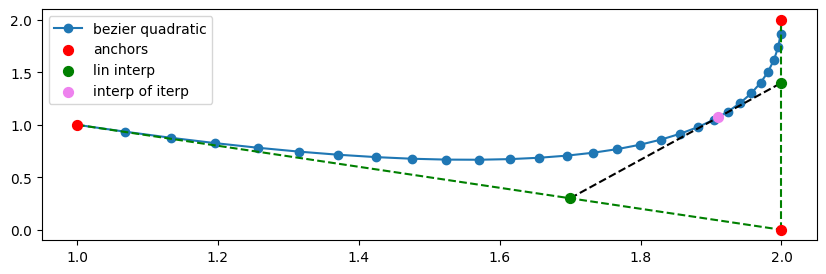

In [38]:
P0, P1, P2 = P = np.array([[1,1], [2,0], [2,2]])  
Q0 = lambda t: bezier_line(t.reshape((-1,1)), P0, P1)
Q1 = lambda t: bezier_line(t.reshape((-1,1)), P1, P2)
Q = lambda t: bezier_line(t.reshape((-1,1)), Q0(t), Q1(t))

p1 = Q(times).T
fig,ax = plt.subplots(1,1, figsize = (10,3))
ax.plot(*p1, '-o', label = 'bezier quadratic')

ax.scatter(*P.T, c='r', s = 50, zorder = 10, label='anchors')
ax.plot(*P[:2].T, 'g', ls='dashed')
ax.plot(*P[1:].T, 'g', ls='dashed')
midpoint = np.array([0.7])
P012 = np.array([Q0(midpoint),Q1(midpoint)]). reshape(2,2)
ax.scatter(*P012.T, c='g', s = 50, zorder = 10, label='lin interp')

ax.plot(*P012.T, 'k', ls='dashed');
ax.scatter(*Q(midpoint).T, c='violet', s = 50, zorder = 10, label= 'interp of iterp')
plt.legend()

Note that entire Bezier curve is inside triangle with sides formed by anchors $\{\vec{P}_i\}_1^3$

Or we can rewrite 

$$\vec{Q}(t;\vec{Q}_0(t),\vec{Q}_1(t)) =  (1-t) \cdot \vec{Q}_0(t) + t \cdot \vec{Q}_1(t)$$
$$\vec{Q}(t;\vec{P}_0,\vec{P}_1,\vec{P}_2) = (1-t)\big[(1-t)\vec{P}_0 + t \vec{P}_1\big] + t \big[(1-t)\vec{P}_1 + t \vec{P}_2\big]$$
$$\boxed{\vec{Q}(t;\vec{P}_0,\vec{P}_1,\vec{P}_2) = (1-t)^2 \vec{P}_0 + 2t(1-t)\vec{P}_1 + t^2 \vec{P}_2}$$

notice there is one more anchor point than order of Bezier curve

In [39]:
bezier_quadratic = lambda t, P0, P1, P2: (1-t)**2*P0 + 2*t*(1-t)*P1 + t**2*P2
QQ = lambda t: bezier_quadratic(t.reshape((-1,1)), P0, P1, P2)
np.allclose(QQ(times),Q(times))

True

## de Casteljau’s Algorithm

we have seen that for second order (quadratic) Bezier curve we can write
$$\vec{Q}(t;\vec{Q}_0(t),\vec{Q}_1(t)) =  (1-t) \cdot \vec{Q}_0(t) + t \cdot \vec{Q}_1(t)$$
where interpolated one-order-lower anchor points $\vec{Q}_0(t)$ are parametrized by $t$ and we can expand this expression until we reach original non-parametrized anchor points

We change notation. For Bezier curve of oder $D$ we write:
*   $\vec{P}_i^0$ - for base (or 'lowest order') anchors, of which there are $D+1$, where $i \in \{0,1,\dots, D+1 \}$. 
*   $\vec{P}_i^d$ - for 'higher order' time-parametrized point, where $d \in \{d, d-1, \dots. 1\}$. 

    (Only 1 point for $d=D$ that slides along a Bezier curve)

So de Casteljau’s algorithm show this hierarchical structure as follows
$$\vec{P}_i^d(t) = (1-t) \cdot \vec{P}_i^{d-1}(t) + t \cdot \vec{P}_i^{d-1}(t)$$


## Matrix notation
$$\vec{P}_0^2(t;\vec{P}_0^0,\vec{P}_1^0,\vec{P}_2^0) = (1-t)^2 \vec{P}_0^0 + 2t(1-t)\vec{P}_1^0 + t^2 \vec{P}_2^0=$$

we can expand expression for quadratic BC in terms of powers of $t$ (change notation back for simplicity)

$$ = \big[1 - 2t + t^2\big]\vec{P}_0 + \big[ 2t - 2t^2\big] \vec{P}_1 + t^2\vec{P}_2$$
$$ = \big[\vec{P}_0 - 2 \vec{P}_1  + \vec{P}_2 \big]t^2 + \big[ -2\vec{P}_0  + 2 \vec{P}_1\big] t + \vec{P}_0 $$

We can 'sort of' see two dot products
$$ = 
\underbrace{
\underbrace{
\begin{bmatrix}
\big(\vec{P}_0 - 2 \vec{P}_1  + \vec{P}_2 \big) &
\big( -2\vec{P}_0  + 2 \vec{P}_1\big) &
\vec{P}_0
\end{bmatrix}
}_{\text{result of dot 1}}
\begin{bmatrix}
t^2 \\ t \\ 1
\end{bmatrix}}_{\text{dot 2}}
$$

and




dot #2 is kind of obvious if we ignore that elements are vectors (although its a 3x3 matrix on the left. so dot is legit)

dot #1 results in ~ 1x3 matrix. if we can stack 3x3 matrix $P$ from initial control point vectors $\vec{P}_i$:
$$P = \begin{bmatrix} \vec{P}_0 &  \vec{P}_1  & \vec{P}_2 \end{bmatrix} \ ; \ P^T = \begin{bmatrix} \vec{P}_0^T \\ \vec{P}_1^T  \\ \vec{P}_2^T \end{bmatrix} $$

$$
\begin{bmatrix} 
1 & -2 & 1 \\
-2 & 2 & 0 \\
1 & 0 & 0
\end{bmatrix} 
\begin{bmatrix} \vec{P}_0^T \\ \vec{P}_1^T  \\ \vec{P}_2^T \end{bmatrix} 
=


\begin{bmatrix} 
1 \\
-2 \\
1 
\end{bmatrix}  \vec{P}_0^T 
+

\begin{bmatrix} 
-2 \\
2 \\
0 
\end{bmatrix}  \vec{P}_1^T 
+

\begin{bmatrix} 
1 \\
0 \\
0 
\end{bmatrix}  \vec{P}_2^T
=
\begin{bmatrix} 
\vec{P}_0^T - 2 \vec{P}_1^T  + \vec{P}_2^T \\
-2\vec{P}_0^T  + 2 \vec{P}_1^T \\
\vec{P}_0^T
\end{bmatrix}
$$
due to symmetry of left matrix we can transpose
$$A P = B \rightarrow P^T A^T = P^T A = B^T$$

$$\begin{bmatrix} \vec{P}_0 &  \vec{P}_1  & \vec{P}_2 \end{bmatrix}
\begin{bmatrix} 
1 & -2 & 1 \\
-2 & 2 & 0 \\
1 & 0 & 0
\end{bmatrix} =

\begin{bmatrix} 
\big(\vec{P}_0 - 2 \vec{P}_1  + \vec{P}_2 \big) &&
\big( -2\vec{P}_0  + 2 \vec{P}_1\big) &&
\vec{P}_0
\end{bmatrix}


We can conclude that 
$$\vec{P}_0^2(t;\vec{P}_0,\vec{P}_1,\vec{P}_2) =
\underbrace{
\begin{bmatrix} \vec{P}_0 &  \vec{P}_1  & \vec{P}_2 \end{bmatrix}
}_{\text{only curve parameters}}
\begin{bmatrix} 
1 & -2 & 1 \\
-2 & 2 & 0 \\
1 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
t^2 \\ t \\ 1
\end{bmatrix}$$

note that right part is universal for any Cubic BC. Left is curve-specific

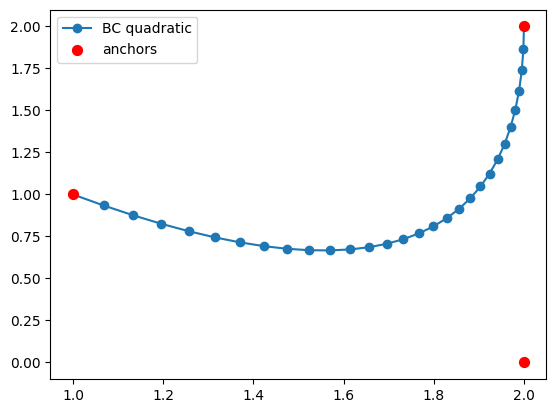

In [40]:
Q_BC_matrix = lambda P, t: P @ np.array([[1,-2,1],[-2,2,0],[1,0,0]]) @ np.array([t**2, t**1, t**0]) # times dims (3,N), so overall (2,3) x (3,3) x (3,N) = (2,N)
plt.plot(*Q_BC_matrix(P.T,times), '-o', label = 'BC quadratic')
plt.scatter(*P.T, c='r', s = 50, zorder = 10, label='anchors')
plt.legend();

## Cubic Bezier Curve

with four control points

$$\vec{P}_0^3(t;\vec{P}_0^0,\vec{P}_1^0,\vec{P}_2^0,\vec{P}_3^0) = (1-t)^3 \vec{P}_0^0 + 3t(1-t)^2\vec{P}_1^0 + 3t^2(1-t) \vec{P}_2^0+ t^3\vec{P}_2^0$$


and coefficient matrix is
$$
\begin{bmatrix} 
-1 & 3 & -3 & 1 \\
3 & -6 & 3 & 0\\
-3 & 3 & 0 & 0 \\
1 & 0 & 0 & 0
\end{bmatrix}$$

## Bernstein Polynomials

degree $p$ Bezier curve
$$\boxed{\mathbb{C}^p = \sum_{i=0}^p B_i^p(t) \vec{P}_i}$$
where 
$$B_i^p(t) = {p\choose i} t^i(1-t)^{p-i}$$
and $${p\choose i} = \frac{p!}{i!(p-i)!}$$
note 
$$\sum_{i=0}^p B_i^p(t) = 1$$
***

### Proof:

We can use binomial (theorem) formula
https://en.wikipedia.org/wiki/Binomial_theorem 
$$\boxed{(x+y)^n = \sum_{k=0}^n {n \choose k} x^{n-k}y^k}$$
to express 
$$\sum_{i=0}^p B_i^p = \sum_{i=0}^p{p\choose i} t^i(1-t)^{p-i}$$

by renaming $$n \leftrightarrow p \;\ k \leftrightarrow i \;\ y \leftrightarrow t \ ; \ x \leftrightarrow 1-t $$
$$(x+y)^p = \sum_{i=0}^p {p \choose k} x^{p-i}y^i \rightarrow$$
$$\rightarrow (1 -\cancel{t+ t})^p = \sum_{i=0}^p {p \choose k} (1-t)^{p-i}t^i = \sum_{i=0}^p B_i^p$$

$$\boxed{\sum_{i=0}^p B_i^p = 1^p = 1}$$
***

### Test in python

In [64]:
from sympy import binomial, Symbol
p = Symbol('p', integer=True, positive=True)
t = Symbol('t', real=True)
B = lambda p,i,t: binomial(p,i)*t**i*(1-t)**(p-i)

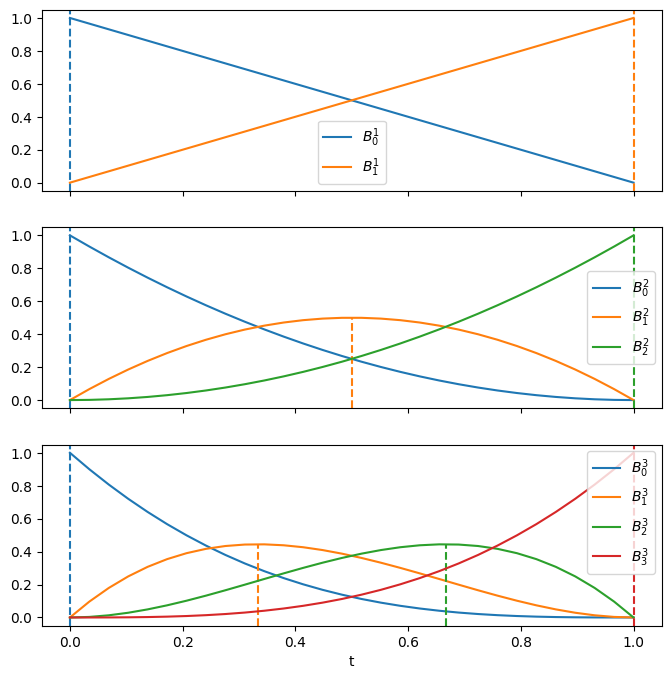

In [70]:
fig,ax = plt.subplots(3,1, figsize = (8,8), sharex=1, sharey=1)
ax[-1].set_xlabel('t')
for p in [1,2,3]:
    for i in range(0,p+1):
        l = ax[p-1].plot(times, B(p,i,times), label = f'$B_{i}^{p}$')
        max_pos = i/p
        ax[p-1].axvline(x=max_pos, ymin=0, ymax = B(p,i,max_pos), linestyle='dashed', c = l[-1].get_c())
    ax[p-1].legend()


#### Observations:
* Bernstein polynomials are non-negative at $t\in [0,1]$
* $B_0^p(t=0) = 1$ and $B_p^p(t=1) = 1$ (first and last)
* Single maximum at $t = \frac{i}{p}$

### Linear Bernstein polynomials $p=1$:
$$\mathbb{C}^1 = \sum_{i=0}^1 B_i^p(t) \vec{P}_i=  B_0^1(t) \vec{P}_0 +  B_1^1(t) \vec{P}_1$$

In [49]:
p = 1;[B(p,i,t) for i in range(0,p+1)]

[1 - t, t]

$$\mathbb{C}^1  = B_0^1(t) \vec{P}_0 +  B_1^1(t) \vec{P}_1 = (1-t)\cdot\vec{P}_0  + t \cdot \vec{P}_1$$
same as old result

### Quadratic Bernstein polynomials $p=2$

In [54]:
p = 2;[B(p,i,t) for i in range(0,p+1)]

[(1 - t)**2, 2*t*(1 - t), t**2]

Comparing to old result
$$\vec{P}_0^2(t;\vec{P}_0^0,\vec{P}_1^0,\vec{P}_2^0) = (1-t)^2 \vec{P}_0^0 + 2t(1-t)\vec{P}_1^0 + t^2 \vec{P}_2^0=$$

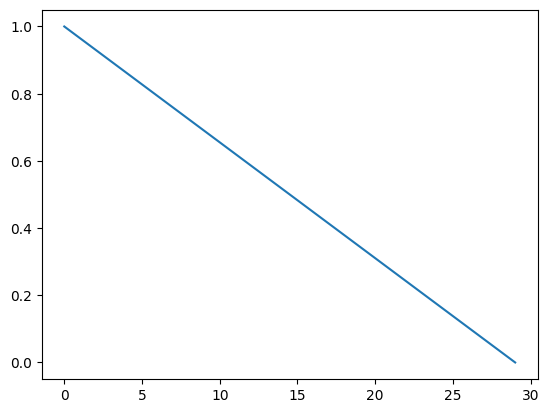

In [75]:
from scipy.stats import binom

plt.plot(binom.pmf(0, 1, times))

In [76]:
def true_func(x):
  return np.sin(8 * np.pi * x) / np.exp(x) + x

m = 30
sigma = 0.1

# generate features
np.random.seed(42)
X = np.random.rand(m)
y = true_func(X) + sigma * np.random.randn(m)